<a href="https://colab.research.google.com/github/abdusalam7474/Contract_review_Nig/blob/main/Cp3_Speech_Recog_And_Translat_ion_v3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
cd /content/drive/MyDrive/Speech_Recog_And_Translation/SpeechCmdRecognition

/content/drive/MyDrive/Speech_Recog_And_Translation/SpeechCmdRecognition


In [ ]:
#!cp /content/SpeechCmdRecognition/model-attRNN.h5 /content/drive/MyDrive/Speech_Recog_And_Translation/SpeechCmdRecognition

In [ ]:
!pip install -r requirements.txt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 578.1/578.1 MB 2.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 65.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 3.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 58.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.9/5.9 MB 82.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 438.7/438.7 kB 38.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 90.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 781.3/781.3 kB 48.9 MB/s eta 0:00:00
  Attempting uninstall: keras
    Found existing installation: keras 2.13.1
    Uninstalling keras-2.13.1:
      Successfully uninstalled keras-2.13.1
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.13.0
    Uninstalling tensorflow-estimator-2.13.0:
      Successfully uninstalled tensorflow-estimator-2.13.0

In [ ]:
%pip install librosa -q

In [ ]:
# import os
# os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

import tensorflow as tf
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]

In [ ]:
%load_ext autoreload
%autoreload 2

import matplotlib
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import SpeechDownloader
import SpeechGenerator
import SpeechModels
import audioUtils

In [ ]:
inp = tf.zeros( (2, 16000), dtype=tf.float32)
inp.shape
# audioUtils.normalized_mel_spectrogram( )

TensorShape([2, 16000])

In [ ]:
inp * 3

<tf.Tensor: shape=(2, 16000), dtype=float32, numpy=
array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)>

In [ ]:
stft = tf.signal.stft(
    inp,
    frame_length=1024,
    frame_step=128,
    window_fn=tf.signal.hann_window,
    pad_end=True,
)
stft.shape

TensorShape([2, 125, 513])

In [ ]:
cd /content

/content


In [ ]:
# Download and prepare all data
gscInfo, nCategs = SpeechDownloader.PrepareGoogleSpeechCmd(version=2, task='35word')

We should have 4 datasets, each with file names 'files' and their categories 'labels' in a dict.

In [ ]:
print(gscInfo.keys())
print(gscInfo['train'].keys())
print(len(gscInfo['train']['files']))
print(nCategs)

dict_keys(['train', 'test', 'val', 'testREAL'])
dict_keys(['files', 'labels'])
84849
36


In [ ]:
import os
os.listdir("/content/sd_GSCmdV2/train/five")

# Speech Data Generator

Use Keras to create a generator that reads files on the fly.

In [ ]:

nCategs = 36
sr = 16000 #we know this one for google audios
iLen = 16000
trainGen = SpeechGenerator.SpeechGen(gscInfo['train']['files'], gscInfo['train']['labels'], shuffle=True)
# handle the fact that number of samples in validation may not be multiple of batch_size with shuffle=True
valGen   = SpeechGenerator.SpeechGen(gscInfo['val']['files'], gscInfo['val']['labels'], shuffle=True)

# use batch_size = total number of files to read all test files at once
testGen  = SpeechGenerator.SpeechGen(gscInfo['test']['files'], gscInfo['test']['labels'], shuffle=False, batch_size=len(gscInfo['test']['files']))
testRGen = SpeechGenerator.SpeechGen(gscInfo['testREAL']['files'], gscInfo['testREAL']['labels'], shuffle=False, batch_size=len(gscInfo['testREAL']['files']))
valGen.__len__()

NameError: ignored

In [ ]:
audios, classes = valGen.__getitem__(5)
classes

array([ 4, 13, 32, 29,  3,  1,  2, 11, 35, 17, 19, 10, 32,  1, 15, 14, 16,
       28, 17, 10,  5,  5,  3, 34, 25,  5,  2, 33,  8, 30, 17, 27])

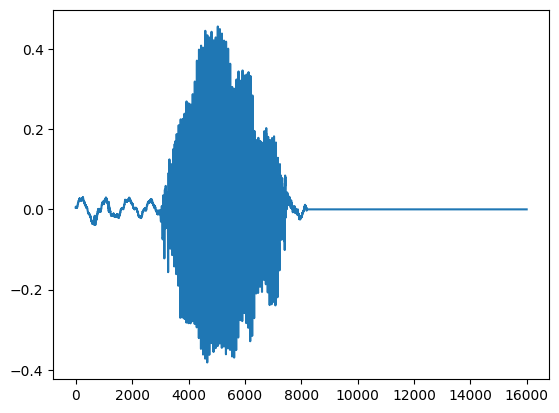

In [ ]:
# librosa.output.write_wav('file.wav', audios[4], sr, norm=False)
plt.plot(audios[4])

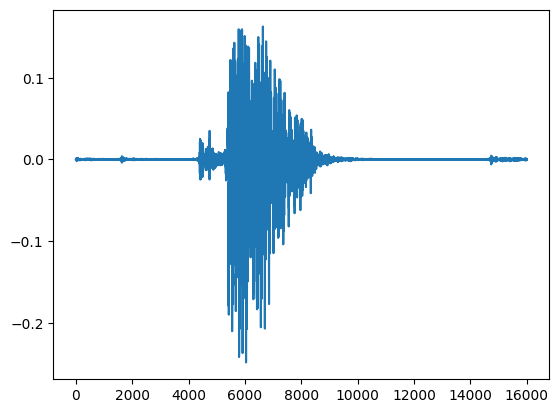

In [ ]:
plt.plot(audios[1])

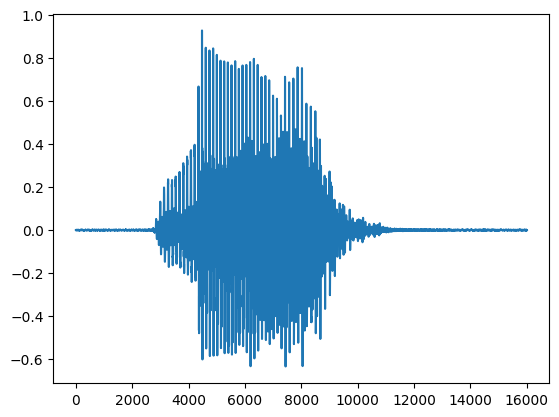

In [ ]:
plt.plot(audios[2])

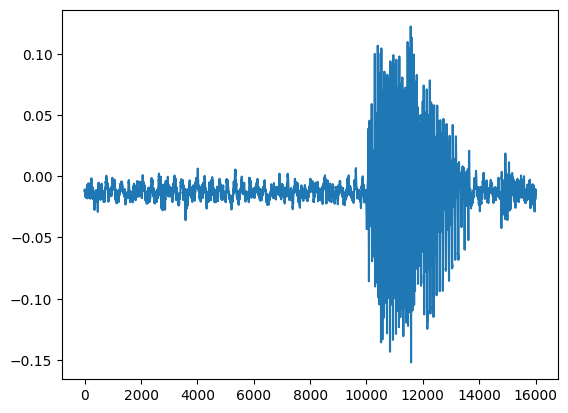

In [ ]:
plt.plot(audios[3])

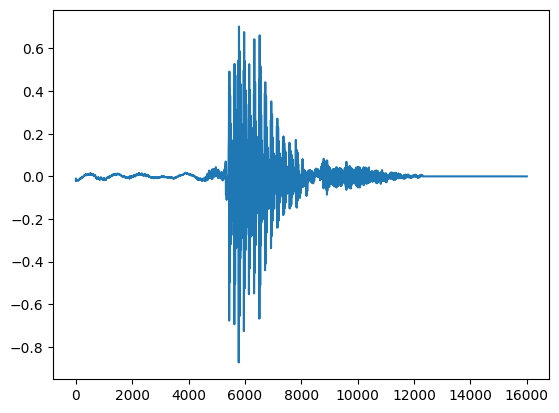

In [ ]:
plt.plot(audios[0])

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers as L
from tensorflow.keras import Model

inp = L.Input((iLen,), name='input')
mel_spec = audioUtils.normalized_mel_spectrogram(inp)
melspecModel = Model(inputs=inp, outputs=mel_spec, name='normalized_spectrogram_model')

melspecModel.summary()

Model: "normalized_spectrogram_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, 16000)]      0           []                               
                                                                                                  
 tf.signal.stft (TFOpLambda)    (None, 125, 513)     0           ['input[0][0]']                  
                                                                                                  
 tf.math.abs (TFOpLambda)       (None, 125, 513)     0           ['tf.signal.stft[0][0]']         
                                                                                                  
 tf.tensordot (TFOpLambda)      (None, 125, 80)      0           ['tf.math.abs[0][0]']            
                                                                       

In [ ]:
audios.shape

(32, 16000)

In [ ]:
melspec = melspecModel.predict(audios)
melspec.shape

np.min(melspec[9,:,:].T), np.max(melspec[9,:,:].T), np.mean(melspec[9,:,:].T)

1/1 [==============================] - 4s 4s/step


(-2.3397481, 2.749462, 0.07520337)

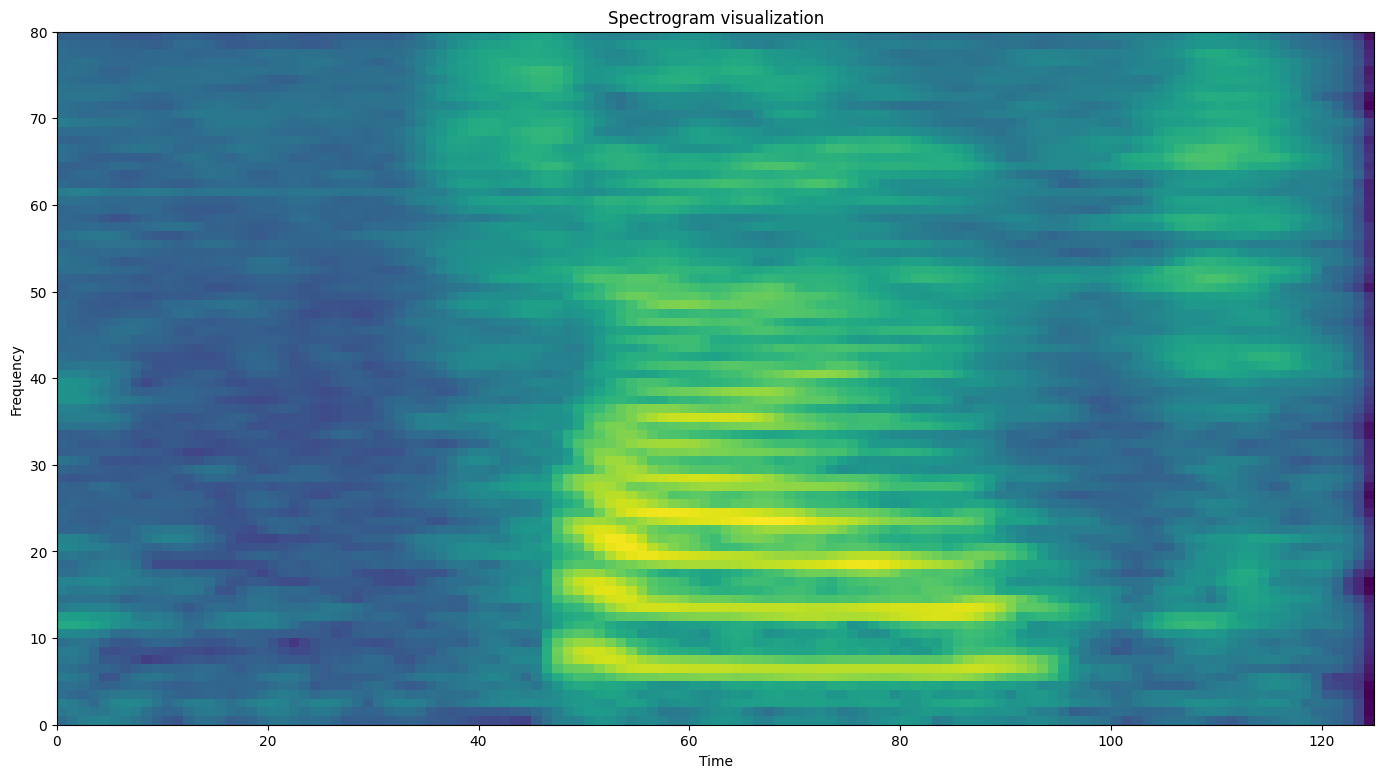

In [ ]:
plt.figure(figsize=(17,9))
plt.pcolormesh(melspec[9,:,:].T)

plt.title('Spectrogram visualization')
plt.ylabel('Frequency')
plt.xlabel('Time')

plt.show()

In [ ]:
import librosa

# Check if mel spectrogram matches the one computed with librosa
librosa_melspec = librosa.feature.melspectrogram(y=audios[9], sr=sr, n_fft=1024,
                                                 hop_length=128, power=1.0, #window='hann',
                                                 n_mels=80, fmin=40.0, fmax=sr/2)
S_dB = librosa.power_to_db(librosa_melspec, ref=np.max)
np.min(S_dB), np.max(S_dB)

(-47.28102330784931, 0.0)

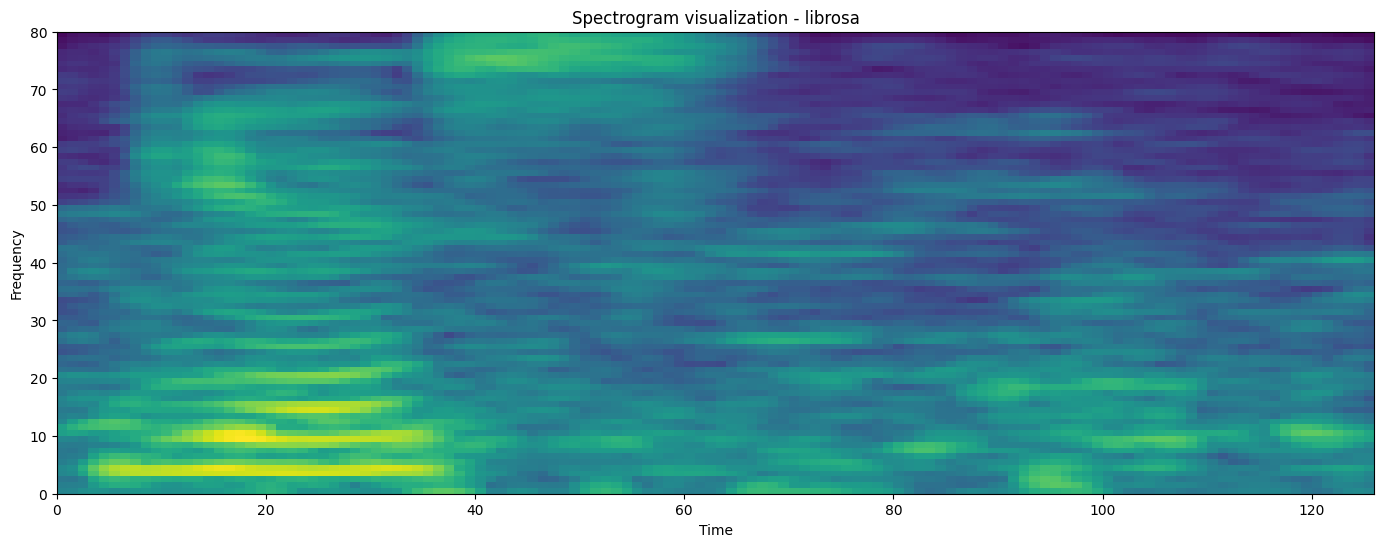

In [ ]:
plt.figure(figsize=(17,6))
plt.pcolormesh(S_dB)

plt.title('Spectrogram visualization - librosa')
plt.ylabel('Frequency')
plt.xlabel('Time')

plt.show()

In [ ]:
plt.hist(melspec.flatten(), bins=100)
plt.show()

# Models

Create Keras models to see if the generators are working properly

In [ ]:
from tensorflow.keras.models import Model, load_model

In [ ]:
model = SpeechModels.AttRNNSpeechModel(nCategs, samplingrate = sr, inputLength = None)#, rnn_func=L.LSTM)

model.compile(optimizer='adam', loss=['sparse_categorical_crossentropy'], metrics=['sparse_categorical_accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, None)]       0           []                               
                                                                                                  
 normalized_spectrogram_model (  (None, None, 80)    0           ['input[0][0]']                  
 Functional)                                                                                      
                                                                                                  
 tf.expand_dims (TFOpLambda)    (None, None, 80, 1)  0           ['normalized_spectrogram_model[0]
                                                                 [0]']                            
                                                                                              

In [ ]:
model.load_weights('/content/drive/MyDrive/Speech_Recog_And_Translation/SpeechCmdRecognition/modelattRNN.h5')

In [ ]:
import math
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler
def step_decay(epoch):
    initial_lrate = 0.001
    drop = 0.4
    epochs_drop = 15.0
    lrate = initial_lrate * math.pow(drop,
            math.floor((1+epoch)/epochs_drop))

    if (lrate < 4e-5):
        lrate = 4e-5

    print('Changing learning rate to {}'.format(lrate))
    return lrate
lrate = LearningRateScheduler(step_decay)

In [ ]:
earlystopper = EarlyStopping(monitor='val_sparse_categorical_accuracy', patience=10,
                             verbose=1, restore_best_weights=True)
checkpointer = ModelCheckpoint('model-attRNN.h5', monitor='val_sparse_categorical_accuracy', verbose=1, save_best_only=True)

results = model.fit(trainGen, validation_data=valGen, epochs=12, use_multiprocessing=False, workers=4, verbose=1,
                    callbacks=[earlystopper, checkpointer, lrate])

model.save('model-attRNN.h5')

Changing learning rate to 0.001
Epoch 1/12
2651/2651 [==============================] - ETA: 0s - loss: 0.7547 - sparse_categorical_accuracy: 0.7833
Epoch 1: val_sparse_categorical_accuracy improved from -inf to 0.89590, saving model to model-attRNN.h5
2651/2651 [==============================] - 161s 55ms/step - loss: 0.7547 - sparse_categorical_accuracy: 0.7833 - val_loss: 0.3652 - val_sparse_categorical_accuracy: 0.8959 - lr: 0.0010
Changing learning rate to 0.001
Epoch 2/12
2651/2651 [==============================] - ETA: 0s - loss: 0.3002 - sparse_categorical_accuracy: 0.9104
Epoch 2: val_sparse_categorical_accuracy improved from 0.89590 to 0.93047, saving model to model-attRNN.h5
2651/2651 [==============================] - 126s 48ms/step - loss: 0.3002 - sparse_categorical_accuracy: 0.9104 - val_loss: 0.2410 - val_sparse_categorical_accuracy: 0.9305 - lr: 0.0010
Changing learning rate to 0.001
Epoch 3/12
2651/2651 [==============================] - ETA: 0s - loss: 0.2311 - spar

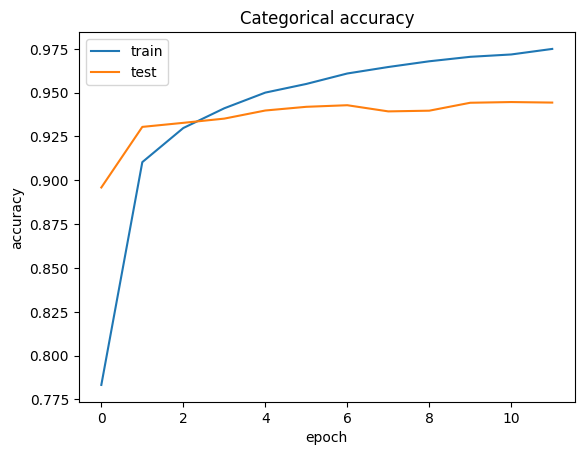

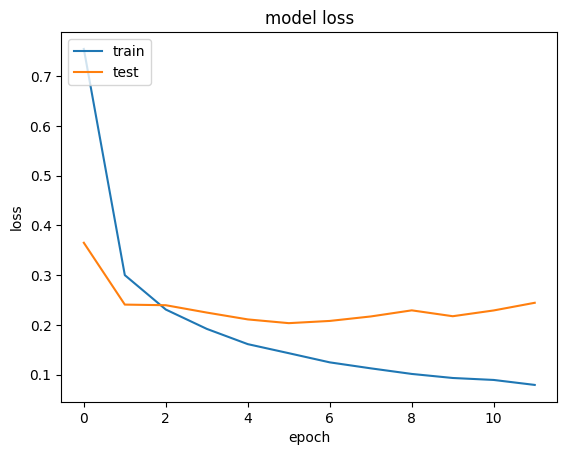

In [ ]:
# summarize history for categorical accuracy
plt.plot(results.history['sparse_categorical_accuracy'])
plt.plot(results.history['val_sparse_categorical_accuracy'])
plt.title('Categorical accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(results.history['loss'])
plt.plot(results.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:

import pandas as pd

#history = model.fit(X_train, y_train, epochs=10)
history_df = pd.DataFrame(results.history)
history_df.to_csv('drowsiness_history.csv', index=False)
history_df.head(50)

,loss,sparse_categorical_accuracy,val_loss,val_sparse_categorical_accuracy,lr
0,0.754739,0.783289,0.365220,0.895900,0.001
1,0.300198,0.910364,0.240990,0.930466,0.001
2,0.231065,0.929826,0.239737,0.932777,0.001
3,0.192179,0.941084,0.224972,0.935189,0.001
4,0.161535,0.950019,0.211224,0.939811,0.001
5,0.143344,0.954958,0.203709,0.941921,0.001
6,0.124913,0.960923,0.208168,0.942826,0.001
7,0.112906,0.964624,0.217159,0.939309,0.001
8,0.101662,0.967889,0.229436,0.939711,0.001
9,0.093526,0.970436,0.217635,0.944232,0.001


In [ ]:
ls

audioUtils.py   __pycache__/      SpeechDownloader.py  SpeechModels.py
modelattRNN.h5  requirements.txt  SpeechGenerator.py   Speech_Recog_Demo.ipynb


In [ ]:

# load best model according to cross-validation - model-attRNN
#model = load_model('/content/SpeechCmdRecognition/model-attRNN.h5', custom_objects={'Melspectrogram': Melspectrogram, 'Normalization2D': Normalization2D })
model.load_weights('/content/SpeechCmdRecognition/model-attRNN.h5')
#model.load_weights("/content/drive/MyDrive/Speech_Recog_And_Translation/SpeechCmdRecognition/modelattRNN.h5")

In [ ]:
# tf.saved_model.save(model, 'model-KWS-attRNN')

In [ ]:
#read all test data
x_test, y_test = testGen.__getitem__(0)

In [ ]:
valEval = model.evaluate(valGen, use_multiprocessing=False, workers=4,verbose=0)
trainEval = model.evaluate(trainGen, use_multiprocessing=False, workers=4,verbose=0)
testEval = model.evaluate(x_test, y_test, verbose=0)
print('Evaluation scores: \nMetrics: {} \nTrain: {} \nValidation: {} \nTest: {}'.format(model.metrics_names, trainEval, valEval, testEval) )

Evaluation scores: 
Metrics: ['loss', 'sparse_categorical_accuracy'] 
Train: [0.06487279385328293, 0.980396568775177] 
Validation: [0.24290257692337036, 0.9439308643341064] 
Test: [0.25490602850914, 0.9389368295669556]


## Evaluation and Attention Plots

In [ ]:
attSpeechModel = Model(inputs=model.input,
                                 outputs=[model.get_layer('output').output,
                                          model.get_layer('attSoftmax').output,
                                          model.get_layer('tf.expand_dims').output])

In [ ]:
audios, classes = valGen.__getitem__(3)
classes

array([17, 12,  4,  5, 35, 21, 27,  8, 18, 11, 11, 20,  3,  1, 32, 22, 20,
       12,  1, 13, 15, 33, 23,  6, 32,  9, 32,  5, 20, 22, 18,  9])

In [ ]:
#8 - on, 13 - one, 7 - right
idAudio = 8
classes[idAudio]

18

In [ ]:
outs, attW, specs = attSpeechModel.predict(audios)

1/1 [==============================] - 1s 1s/step


In [ ]:
np.argmax(outs,axis=1)

array([17, 12,  4,  5, 35,  5, 27,  8, 18, 16, 11, 20,  3,  1, 32, 22, 20,
       12,  1, 13, 15, 33, 23,  6, 32,  9, 32,  5, 20, 22, 18,  9])

In [ ]:
specs.shape

(32, 125, 80, 1)

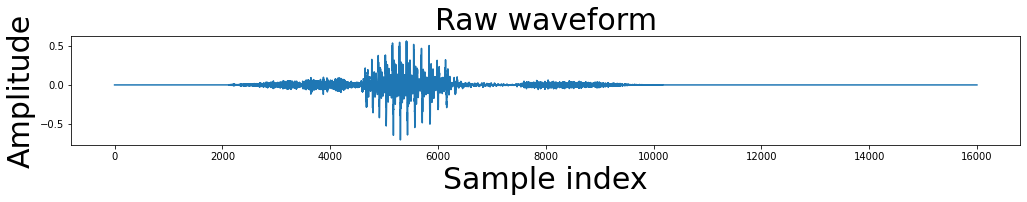

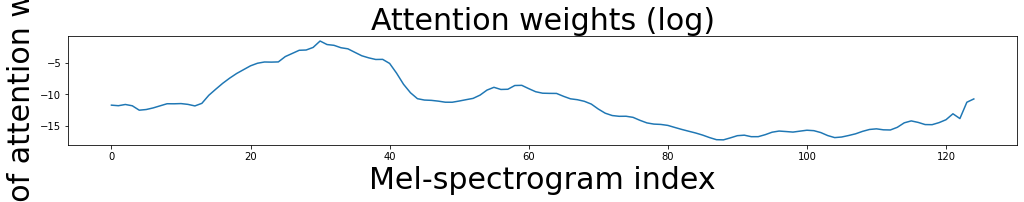

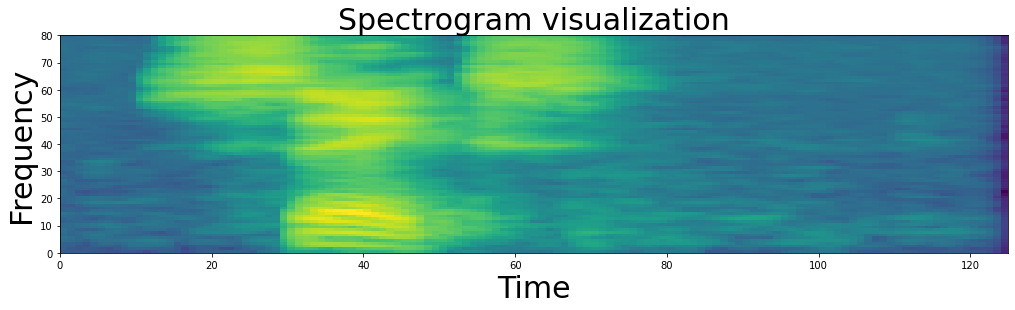

In [ ]:
imgHeight = 2

plt.figure(figsize=(17,imgHeight))
plt.title('Raw waveform', fontsize=30)
plt.ylabel('Amplitude', fontsize=30)
plt.xlabel('Sample index', fontsize=30)
plt.plot(audios[idAudio])
plt.savefig('picrawWave.png', dpi = 400)
plt.show()

plt.figure(figsize=(17,imgHeight))
plt.title('Attention weights (log)', fontsize=30)
plt.ylabel('Log of attention weight', fontsize=30)
plt.xlabel('Mel-spectrogram index', fontsize=30)
plt.plot(np.log(attW[idAudio]))
plt.savefig('picAttention.png', dpi = 400)
plt.show()


plt.figure(figsize=(17,imgHeight*2))
plt.pcolormesh(specs[idAudio,:,:,0].T)

plt.title('Spectrogram visualization', fontsize=30)
plt.ylabel('Frequency', fontsize=30)
plt.xlabel('Time', fontsize=30)
plt.savefig('picmelSpec.png', dpi = 400)

plt.show()

In [ ]:
y_pred = model.predict(x_test, verbose=1)

344/344 [==============================] - 6s 17ms/step


In [ ]:

from sklearn.metrics import classification_report

pred_labels = np.argmax(y_pred, axis=1)
#true_labels = np.argmax(y_test, axis=1)
true_labels = y_test
classification_report = classification_report(true_labels, pred_labels)
print(classification_report)

              precision    recall  f1-score   support

           1       0.94      0.94      0.94       408
           2       0.98      0.98      0.98       419
           3       0.95      0.90      0.92       405
           4       0.94      0.94      0.94       425
           5       0.88      0.95      0.91       406
           6       0.95      0.97      0.96       412
           7       0.98      0.93      0.95       396
           8       0.96      0.93      0.95       396
           9       0.97      0.91      0.94       402
          10       0.98      0.97      0.98       411
          11       0.91      0.90      0.91       402
          12       0.95      0.97      0.96       418
          13       0.97      0.93      0.95       399
          14       0.95      0.95      0.95       424
          15       0.95      0.91      0.93       405
          16       0.95      0.89      0.92       400
          17       0.91      0.98      0.95       445
          18       0.97    

In [ ]:
from sklearn.metrics import confusion_matrix
import audioUtils
cm = confusion_matrix(y_test, np.argmax(y_pred,1))

In [ ]:
#set(y_test)

In [ ]:
#35word, v2
classes = ['nine', 'yes', 'no', 'up', 'down', 'left', 'right', 'on', 'off', 'stop', 'go',
           'zero', 'one', 'two', 'three', 'four', 'five', 'six',
           'seven',  'eight', 'backward', 'bed', 'bird', 'cat', 'dog',
           'follow', 'forward', 'happy', 'house', 'learn', 'marvin', 'sheila', 'tree',
           'visual', 'wow']

In [ ]:
#35word, v1
#classes=['nine', 'yes',  'no', 'up', 'down', 'left', 'right', 'on', 'off', 'stop', 'go',
#         'zero', 'one', 'two', 'three', 'four', 'five', 'six', 'seven',  'eight',
#         'bed', 'bird', 'cat', 'dog', 'happy', 'house',
#         'marvin', 'sheila', 'tree', 'wow']

In [ ]:
#20cmd
#classes=['unknown', 'nine', 'yes',  'no', 'up', 'down', 'left', 'right', 'on', 'off', 'stop', 'go',
#         'zero', 'one', 'two', 'three', 'four', 'five', 'six', 'seven',  'eight']

Confusion matrix, without normalization


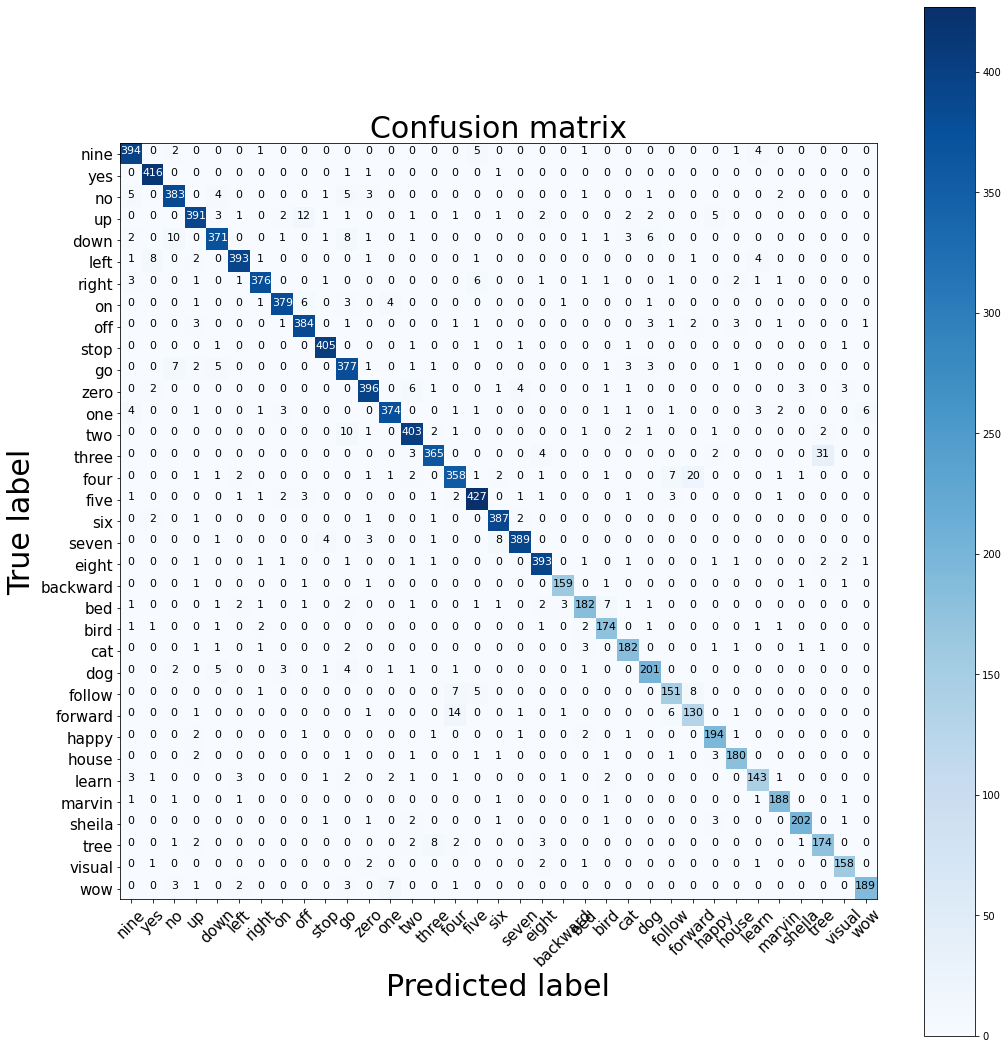

In [ ]:
audioUtils.plot_confusion_matrix(cm, classes, normalize=False)

In [ ]:
import pandas as pd
[tf.__version__, pd.__version__, librosa.__version__]

['2.10.1', '1.5.2', '0.9.2']

In [ ]:

import os
os.listdir("/content/sd_GSCmdV2/train/five")
#/content/sd_GSCmdV2/train/five/c5c60d8d_nohash_1.wav.npy

In [ ]:

#loading sample data
A = np.load("/content/sd_GSCmdV2/train/happy/551e42e8_nohash_0.wav.npy")

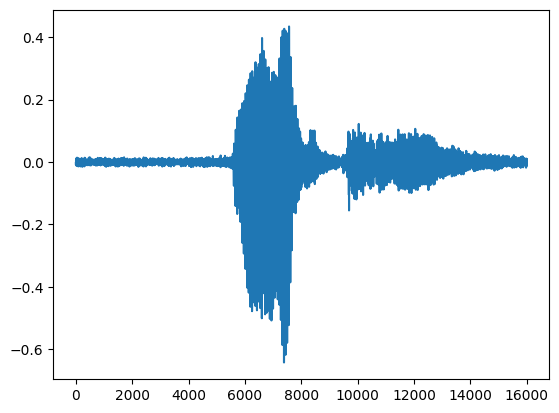

In [ ]:
plt.plot(A)

In [ ]:
res = speech_model.predict(A)

500/500 [==============================] - 3s 6ms/step


In [ ]:
res.shape

(16000, 36)

In [ ]:
np.argmax(res,1)

array([20, 20, 20, ..., 20, 20, 20])

# Save model

In [ ]:
model_16000 = SpeechModels.AttRNNSpeechModel(nCategs, samplingrate = sr, inputLength = None)
model_16000.load_weights('model-attRNN.h5')

tf.saved_model.save(model_16000, 'model-KWS-attRNN')

In [ ]:
model_16000 = tf.saved_model.load('model-KWS-attRNN')

In [ ]:
# Convert the model
converter = tf.lite.TFLiteConverter.from_saved_model('model-KWS-attRNN') # path to the SavedModel directory

converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS, tf.lite.OpsSet.SELECT_TF_OPS]
converter._experimental_lower_tensor_list_ops = False

tflite_model = converter.convert()

# Save the model.
with open('model-KWS-attRNN.tflite', 'wb') as f:
    f.write(tflite_model)

#Test commands

In [ ]:

import librosa
import numpy as np

# Set the desired sample rate and audio length
sr = 16000
iLen = 16000

# Path to the recorded audio file
audio_path = '/content/sd_GSCmdV2/test/yes/03401e93_nohash_0.wav'

# Step 1: Read the audio file
audio, _ = librosa.load(audio_path, sr=sr)

# Step 2: Resample the audio
audio = librosa.resample(audio, orig_sr=sr, target_sr=sr)

# Step 3: Normalize the audio
audio = audio / np.max(np.abs(audio))

# Step 4: Split the audio into chunks
if len(audio) < iLen:
    # Pad the audio with silence if it's shorter than the desired length
    audio = np.pad(audio, (0, iLen - len(audio)), 'constant')
else:
    # Split the audio into chunks of the desired length
    n_chunks = len(audio) // iLen
    audio = np.array_split(audio[:n_chunks * iLen], n_chunks)

In [ ]:
audio = np.asarray(audio)

In [ ]:
prediction = model.predict(audio)

In [ ]:
prediction.shape

(5, 36)

In [ ]:
#35word, v2
classes = ['nine', 'yes', 'no', 'up', 'down', 'left', 'right', 'on', 'off', 'stop', 'go',
           'zero', 'one', 'two', 'three', 'four', 'five', 'six',
           'seven',  'eight', 'backward', 'bed', 'bird', 'cat', 'dog',
           'follow', 'forward', 'happy', 'house', 'learn', 'marvin', 'sheila', 'tree',
           'visual', 'wow']

In [ ]:
np.argmax(prediction[4])

# Translation

In [ ]:
cd /content/drive/MyDrive/Speech_Recog_And_Translation/translator

/content/drive/MyDrive/Speech_Recog_And_Translation/translator


In [ ]:
%load_ext autoreload
%aimport helper, tests
%autoreload 1

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
pip install keras_preprocessing

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 2.1 MB/s eta 0:00:00


In [ ]:
import collections
import pickle
import helper
import numpy as np
import project_tests as tests

from keras.preprocessing.text import Tokenizer
from keras.models import load_model

from keras_preprocessing.sequence import pad_sequences
from keras.models import Model, Sequential
from keras.layers import GRU, Input, Dense, TimeDistributed, Activation, RepeatVector, Bidirectional, Dropout, LSTM
from keras.layers import Embedding
from keras.optimizers import Adam
from keras.losses import sparse_categorical_crossentropy

In [ ]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 10909777935264702055
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 14368440320
locality {
  bus_id: 1
  links {
  }
}
incarnation: 3907135160760466429
physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"
xla_global_id: 416903419
]


loading data

In [ ]:
# Load English data
english_sentences = helper.load_data('data/small_vocab_en.txt')
# Load yoruba data
yoruba_sentences = helper.load_data('data/small_vocab_yor.txt')

print('Dataset Loaded')

Dataset Loaded


In [ ]:
len(english_sentences)

56

In [ ]:
len(yoruba_sentences)

56

In [ ]:
for sample_i in range(10):
    print('English sample {}:  {}'.format(sample_i + 1, english_sentences[sample_i]))
    print('yoruba sample {}:  {}\n'.format(sample_i + 1, yoruba_sentences[sample_i]))

English sample 1:  I might travel out to a quiet place in the month of January. .
yoruba sample 1:  Ó sése kí n rin  ìrìn àjò lọ sí ibi tó farasin ní oṣù January.

English sample 2:  I like to take a nap immediately after lunch everyday.
yoruba sample 2:  Mo fẹ́ràn láti rẹjú ní wàrawàra lẹ̀yìn oúnjẹ ò̩sán lojojúmọ́.

English sample 3:  I  don’t like going out to parties with friends but I like watching TV..
yoruba sample 3:  Mo kórìíra láti máa lo sí àpèjẹ pèlú àwọn ọ̀rẹ́ mi ṣùgbọ́n mo fẹ́ràn láti máa wo tẹlifíṣọ̀n

English sample 4:  To my horror, I noticed that there was a photograph of someone in a military uniform in the hallway.
yoruba sample 4:  Ẹ̀rù bà mí nígbà tí mo rí fọ́tò ẹnì kan tó wọ aṣọ ológun ní ọ̀dẹ̀dẹ̀ ilé náà.

English sample 5:  We plant and water, but God makes it grow.
yoruba sample 5:  À ń gbìn, a sì ń bomi rin, àmọ́ Ọlọ́run ló ń mú kó dàgbà

English sample 6:  Pregnant women who smoke endanger their unborn babies.
yoruba sample 6:  Ńṣe làwọn abo

In [ ]:
english_words_counter = collections.Counter([word for sentence in english_sentences for word in sentence.split()])
yoruba_words_counter = collections.Counter([word for sentence in yoruba_sentences for word in sentence.split()])

print('{} English words.'.format(len([word for sentence in english_sentences for word in sentence.split()])))
print('{} unique English words.'.format(len(english_words_counter)))
print('10 Most common words in the English dataset:')
print('"' + '" "'.join(list(zip(*english_words_counter.most_common(10)))[0]) + '"')
print()
print('{} yoruba words.'.format(len([word for sentence in yoruba_sentences for word in sentence.split()])))
print('{} unique yoruba words.'.format(len(yoruba_words_counter)))
print('10 Most common words in the yoruba dataset:')
print('"' + '" "'.join(list(zip(*yoruba_words_counter.most_common(10)))[0]) + '"')

257 English words.
207 unique English words.
10 Most common words in the English dataset:
"a" "of" "to" "I" "and" "in" "the" "like" "out" "but"

341 yoruba words.
253 unique yoruba words.
10 Most common words in the yoruba dataset:
"tó" "ń" "tí" "sì" "ni" "wọ́n" "ó" "àwọn" "láti" "mi"


In [ ]:
len("yoruba_sentences")

16

Preprocessing

In [ ]:
def tokenize(x):
    """
    Tokenize x
    :param x: List of sentences/strings to be tokenized
    :return: Tuple of (tokenized x data, tokenizer used to tokenize x)
    """
    # TODO: Implement
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(x)
    return tokenizer.texts_to_sequences(x), tokenizer

tests.test_tokenize(tokenize)

# Tokenize Example output
text_sentences = [
    'The quick brown fox jumps over the lazy dog .',
    'By Jove , my quick study of lexicography won a prize .',
    'This is a short sentence .']
text_tokenized, text_tokenizer = tokenize(text_sentences)
print(text_tokenizer.word_index)
print()
for sample_i, (sent, token_sent) in enumerate(zip(text_sentences, text_tokenized)):
    print('Sequence {} in x'.format(sample_i + 1))
    print('  Input:  {}'.format(sent))
    print('  Output: {}'.format(token_sent))

{'the': 1, 'quick': 2, 'a': 3, 'brown': 4, 'fox': 5, 'jumps': 6, 'over': 7, 'lazy': 8, 'dog': 9, 'by': 10, 'jove': 11, 'my': 12, 'study': 13, 'of': 14, 'lexicography': 15, 'won': 16, 'prize': 17, 'this': 18, 'is': 19, 'short': 20, 'sentence': 21}

Sequence 1 in x
  Input:  The quick brown fox jumps over the lazy dog .
  Output: [1, 2, 4, 5, 6, 7, 1, 8, 9]
Sequence 2 in x
  Input:  By Jove , my quick study of lexicography won a prize .
  Output: [10, 11, 12, 2, 13, 14, 15, 16, 3, 17]
Sequence 3 in x
  Input:  This is a short sentence .
  Output: [18, 19, 3, 20, 21]


In [ ]:
def pad(x, length=None):
    """
    Pad x
    :param x: List of sequences.
    :param length: Length to pad the sequence to.  If None, use length of longest sequence in x.
    :return: Padded numpy array of sequences
    """
    # TODO: Implement
    return pad_sequences(x, maxlen=length, padding='post')

tests.test_pad(pad)

# Pad Tokenized output
test_pad = pad(text_tokenized)
for sample_i, (token_sent, pad_sent) in enumerate(zip(text_tokenized, test_pad)):
    print('Sequence {} in x'.format(sample_i + 1))
    print('  Input:  {}'.format(np.array(token_sent)))
    print('  Output: {}'.format(pad_sent))

Sequence 1 in x
  Input:  [1 2 4 5 6 7 1 8 9]
  Output: [1 2 4 5 6 7 1 8 9 0]
Sequence 2 in x
  Input:  [10 11 12  2 13 14 15 16  3 17]
  Output: [10 11 12  2 13 14 15 16  3 17]
Sequence 3 in x
  Input:  [18 19  3 20 21]
  Output: [18 19  3 20 21  0  0  0  0  0]


In [ ]:
def preprocess(x, y):
    """
    Preprocess x and y
    :param x: Feature List of sentences
    :param y: Label List of sentences
    :return: Tuple of (Preprocessed x, Preprocessed y, x tokenizer, y tokenizer)
    """
    preprocess_x, x_tk = tokenize(x)
    preprocess_y, y_tk = tokenize(y)

    preprocess_x = pad(preprocess_x)
    preprocess_y = pad(preprocess_y)

    # Keras's sparse_categorical_crossentropy function requires the labels to be in 3 dimensions
    preprocess_y = preprocess_y.reshape(*preprocess_y.shape, 1)

    return preprocess_x, preprocess_y, x_tk, y_tk

preproc_english_sentences, preproc_yoruba_sentences, english_tokenizer, yoruba_tokenizer =\
    preprocess(english_sentences, yoruba_sentences)

max_english_sequence_length = preproc_english_sentences.shape[1]
max_yoruba_sequence_length = preproc_yoruba_sentences.shape[1]
english_vocab_size = len(english_tokenizer.word_index)
yoruba_vocab_size = len(yoruba_tokenizer.word_index)

print('Data Preprocessed')
print("Max English sentence length:", max_english_sequence_length)
print("Max yoruba sentence length:", max_yoruba_sequence_length)
print("English vocabulary size:", english_vocab_size)
print("yoruba vocabulary size:", yoruba_vocab_size)

Data Preprocessed
Max English sentence length: 17
Max yoruba sentence length: 31
English vocabulary size: 195
yoruba vocabulary size: 230


In [ ]:
def logits_to_text(logits, tokenizer):
    """
    Turn logits from a neural network into text using the tokenizer
    :param logits: Logits from a neural network
    :param tokenizer: Keras Tokenizer fit on the labels
    :return: String that represents the text of the logits
    """
    index_to_words = {id: word for word, id in tokenizer.word_index.items()}
    index_to_words[0] = '<PAD>'

    return ' '.join([index_to_words[prediction] for prediction in np.argmax(logits, 1)])

print('`logits_to_text` function loaded.')

`logits_to_text` function loaded.


##Model:: Bidirectional model with embeddings

In [ ]:
def model_final(input_shape, output_sequence_length, english_vocab_size, yoruba_vocab_size):
    """
    Build and train a model that incorporates embedding, encoder-decoder, and bidirectional RNN on x and y
    :param input_shape: Tuple of input shape
    :param output_sequence_length: Length of output sequence
    :param english_vocab_size: Number of unique English words in the dataset
    :param yoruba_vocab_size: Number of unique yoruba words in the dataset
    :return: Keras model built, but not trained
    """
    # TODO: Implement

    # Hyperparameters
    learning_rate = 0.003

    # Build the layers
    model = Sequential()
    # Embedding
    model.add(Embedding(english_vocab_size, 128, input_length=input_shape[1],
                         input_shape=input_shape[1:]))
    # Encoder
    model.add(Bidirectional(GRU(128)))
    model.add(RepeatVector(output_sequence_length))
    # Decoder
    model.add(Bidirectional(GRU(128, return_sequences=True)))
    model.add(TimeDistributed(Dense(512, activation='relu')))
    model.add(Dropout(0.5))
    model.add(TimeDistributed(Dense(yoruba_vocab_size, activation='softmax')))
    model.compile(loss=sparse_categorical_crossentropy,
                  optimizer=Adam(learning_rate),
                  metrics=['accuracy'])
    return model

#tests.test_model_final(model_final)

print('Final Model Loaded')

Final Model Loaded


In [ ]:
def final_predictions(x, y, x_tk, y_tk):
    """
    Gets pre.
    :param y_tk: yoruba tokenizer
    """
    # TODO: Train neural network using model_final
    model = model_final(x.shape,y.shape[1],
                        len(x_tk.word_index)+1,
                        len(y_tk.word_index)+1)
    model.summary()
    model.fit(x, y, batch_size=1024, epochs=200, validation_split=0.2)


    ## DON'T EDIT ANYTHING BELOW THIS Looo--oINE
    y_id_to_word = {value: key for key, value in y_tk.word_index.items()}
    y_id_to_word[0] = '<PAD>'

    sentence = 'a secret you can tell others'
    sentence = [x_tk.word_index[word] for word in sentence.split()]
    sentence = pad_sequences([sentence], maxlen=x.shape[-1], padding='post')
    sentences = np.array([sentence[0], x[0]])
    predictions = model.predict(sentences, len(sentences))

    print('Sample 1:')
    print(' '.join([y_id_to_word[np.argmax(x)] for x in predictions[0]]))
    print('Il a vu un vieux camion jaune')
    print('Sample 2:')
    print(' '.join([y_id_to_word[np.argmax(x)] for x in predictions[1]]))
    print(' '.join([y_id_to_word[np.max(x)] for x in y[0]]))


final_predictions(preproc_english_sentences, preproc_yoruba_sentences, english_tokenizer, yoruba_tokenizer)

In [ ]:
x = preproc_english_sentences
y = preproc_yoruba_sentences
x_tk = english_tokenizer
y_tk = yoruba_tokenizer

# TODO: Train neural network using model_final
model = model_final(x.shape,y.shape[1],
                        len(x_tk.word_index)+1,
                        len(y_tk.word_index)+1)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 17, 128)           25088     
                                                                 
 bidirectional_2 (Bidirectio  (None, 256)              198144    
 nal)                                                            
                                                                 
 repeat_vector (RepeatVector  (None, 31, 256)          0         
 )                                                               
                                                                 
 bidirectional_3 (Bidirectio  (None, 31, 256)          296448    
 nal)                                                            
                                                                 
 time_distributed (TimeDistr  (None, 31, 512)          131584    
 ibuted)                                                

In [ ]:
history2 = model.fit(x, y, batch_size=1024, epochs=500, validation_split=0.2)

Epoch 1/500
1/1 [==============================] - 0s 133ms/step - loss: 0.0704 - accuracy: 0.9765 - val_loss: 1.9212 - val_accuracy: 0.8333
Epoch 2/500
1/1 [==============================] - 0s 116ms/step - loss: 0.0746 - accuracy: 0.9699 - val_loss: 1.9590 - val_accuracy: 0.8333
Epoch 3/500
1/1 [==============================] - 0s 86ms/step - loss: 0.0717 - accuracy: 0.9751 - val_loss: 1.9681 - val_accuracy: 0.8333
Epoch 4/500
1/1 [==============================] - 0s 61ms/step - loss: 0.0645 - accuracy: 0.9773 - val_loss: 1.9638 - val_accuracy: 0.8360
Epoch 5/500
1/1 [==============================] - 0s 97ms/step - loss: 0.0704 - accuracy: 0.9714 - val_loss: 1.9575 - val_accuracy: 0.8360
Epoch 6/500
1/1 [==============================] - 0s 64ms/step - loss: 0.0701 - accuracy: 0.9736 - val_loss: 1.9531 - val_accuracy: 0.8360
Epoch 7/500
1/1 [==============================] - 0s 106ms/step - loss: 0.0631 - accuracy: 0.9817 - val_loss: 1.9819 - val_accuracy: 0.8360
Epoch 8/500
1/1 [

In [ ]:


accuracy = history2.history['accuracy']
val_accuracy = history2.history['val_accuracy']
loss = history2.history['loss']
val_loss = history2.history['val_loss']
epochs = range(len(accuracy))

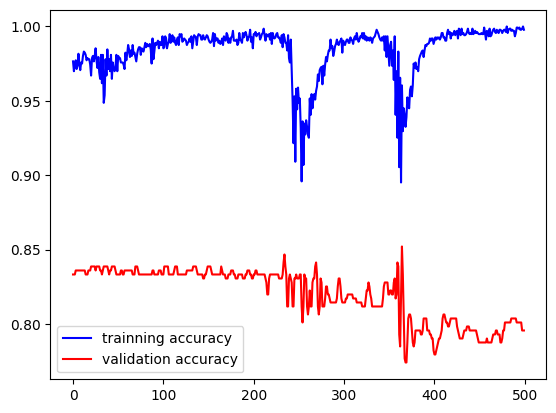

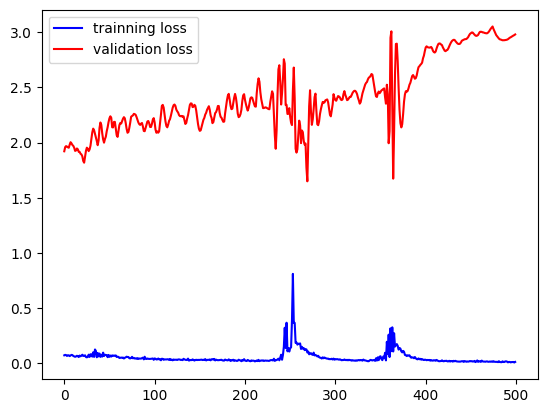

In [ ]:

plt.plot(epochs, accuracy, "b", label="trainning accuracy")
plt.plot(epochs, val_accuracy, "r", label="validation accuracy")
plt.legend()
plt.show()

plt.plot(epochs, loss, "b", label="trainning loss")
plt.plot(epochs, val_loss, "r", label="validation loss")
plt.legend()
plt.show()

In [ ]:

import pandas as pd

#history = model.fit(X_train, y_train, epochs=10)
history_df = pd.DataFrame(history2.history)
history_df.to_csv('translate_history.csv', index=False)
history_df.head(50)

,loss,accuracy,val_loss,val_accuracy
0,0.070361,0.976540,1.921219,0.833333
1,0.074614,0.969941,1.959022,0.833333
2,0.071675,0.975073,1.968065,0.833333
3,0.064516,0.977273,1.963849,0.836021
4,0.070356,0.971408,1.957464,0.836021
5,0.070069,0.973607,1.953064,0.836021
6,0.063140,0.981672,1.981923,0.836021
7,0.068370,0.975073,2.003512,0.836021
8,0.074294,0.970675,1.993050,0.836021
9,0.072346,0.975806,1.978541,0.836021


In [ ]:
 ## DON'T EDIT ANYTHING BELOW THIS LINE
y_id_to_word = {value: key for key, value in y_tk.word_index.items()}
y_id_to_word[0] = '<PAD>'

sentence = 'kidnapping'
sentence = [x_tk.word_index[word] for word in sentence.split()]
sentence = pad_sequences([sentence], maxlen=x.shape[-1], padding='post')
sentences = np.array([sentence[0], x[0]])
predictions = model.predict(sentences, len(sentences))

print('Sample 1:')
print(' '.join([y_id_to_word[np.argmax(x)] for x in predictions[0]]))
print('Il a vu un vieux camion jaune')
print('Sample 2:')
print(' '.join([y_id_to_word[np.argmax(x)] for x in predictions[1]]))
print(' '.join([y_id_to_word[np.max(x)] for x in y[0]]))

1/1 [==============================] - 0s 24ms/step
Sample 1:
nígbà tó kan kan kan <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Il a vu un vieux camion jaune
Sample 2:
ó sése kí n rin ìrìn àjò lọ sí ibi farasin farasin ní oṣù january <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
ó sése kí n rin ìrìn àjò lọ sí ibi tó farasin ní oṣù january <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>


##Ecoder RNN

In [ ]:
def encdec_model(input_shape, output_sequence_length, english_vocab_size, yoruba_vocab_size):
    """
    Build and train an encoder-decoder model on x and y
    :param input_shape: Tuple of input shape
    :param output_sequence_length: Length of output sequence
    :param english_vocab_size: Number of unique English words in the dataset
    :param yoruba_vocab_size: Number of unique yoruba words in the dataset
    :return: Keras model built, but not trained
    """
    # OPTIONAL: Implement

    # Hyperparameters
    learning_rate = 0.001

    # Build the layers
    model = Sequential()
    # Encoder
    model.add(GRU(256, input_shape=input_shape[1:], go_backwards=True))
    model.add(RepeatVector(output_sequence_length))
    # Decoder
    model.add(GRU(256, return_sequences=True))
    model.add(TimeDistributed(Dense(1024, activation='relu')))
    model.add(Dropout(0.5))
    model.add(TimeDistributed(Dense(yoruba_vocab_size, activation='softmax')))

    # Compile model
    model.compile(loss=sparse_categorical_crossentropy,
                  optimizer=Adam(learning_rate),
                  metrics=['accuracy'])

    return model

#tests.test_encdec_model(encdec_model)

# Reshape the input
tmp_x = pad(preproc_english_sentences, preproc_yoruba_sentences.shape[1])
tmp_x = tmp_x.reshape((-1, preproc_yoruba_sentences.shape[-2], 1))

# Train and Print prediction(s)
encdec_rnn_model = encdec_model(
    tmp_x.shape,
    preproc_yoruba_sentences.shape[1],
    len(english_tokenizer.word_index)+1,
    len(yoruba_tokenizer.word_index)+1)

encdec_rnn_model.summary()

encdec_rnn_model.fit(tmp_x, preproc_yoruba_sentences, batch_size=1024, epochs=210, validation_split=0.2)

In [ ]:
## DON'T EDIT ANYTHING BELOW THIS LINE
y_id_to_word = {value: key for key, value in y_tk.word_index.items()}
y_id_to_word[0] = '<PAD>'

sentence = 'A Secret You Can Tell Others'
sentence = [x_tk.word_index[word.lower()] for word in sentence.split()]
sentence = pad_sequences([sentence], maxlen=x.shape[-1], padding='post')
sentences = np.array([sentence[0], x[0]])
'''
predictions = encdec_rnn_model.predict(sentences, len(sentences))

print('Sample 1:')
print(' '.join([y_id_to_word[np.argmax(x)] for x in predictions[0]]))
print('Il a vu un vieux camion jaune')
print('Sample 2:')
print(' '.join([y_id_to_word[np.argmax(x)] for x in predictions[1]]))
print(' '.join([y_id_to_word[np.max(x)] for x in y[0]]))
'''

In [ ]:
tmp_x[:1].shape

(1, 31, 1)

In [ ]:
sentences.shape

(2, 17)

In [ ]:
## DON'T EDIT ANYTHING BELOW THIS LINE
y_id_to_word = {value: key for key, value in y_tk.word_index.items()}
y_id_to_word[0] = '<PAD>'

sentence = 'down'
sentence = [x_tk.word_index[word.lower()] for word in sentence.split()]
sentence = pad_sequences([sentence], maxlen=x.shape[-1], padding='post')
sentences = np.array([sentence[0], x[0]])

In [ ]:
# Reshape the input
tmp_x_ = pad(sentences, preproc_yoruba_sentences.shape[1])
tmp_x_ = tmp_x_.reshape((-1, preproc_yoruba_sentences.shape[-2], 1))

In [ ]:
# Print prediction(s)
print("Prediction:")
print(logits_to_text(encdec_rnn_model.predict(tmp_x_[:1])[0], yoruba_tokenizer))

print("\nCorrect Translation:")
print(yoruba_sentences[2:3])

print("\nOriginal text:")
print(english_sentences[2:3])

Prediction:
1/1 [==============================] - 0s 22ms/step
márùn <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>

Correct Translation:
['Mo kórìíra láti máa lo sí àpèjẹ pèlú àwọn ọ̀rẹ́ mi ṣùgbọ́n mo fẹ́ràn láti máa wo tẹlifíṣọ̀n']

Original text:
['I  don’t like going out to parties with friends but I like watching TV..']


Testing

#downloading sample filesfor testing

In [ ]:

from tqdm import tqdm
import requests
import math
import os
import tarfile
import numpy as np
import pandas as pd

import audioUtils

In [ ]:

def _DownloadGoogleSpeechCmdV2(forceDownload=False):
    """
    Downloads Google Speech commands dataset version 2
    """
    if os.path.isdir("sd_GSCmdV2/") and not forceDownload:
        print('Google Speech commands dataset version 2 already exists. Skipping download.')
    else:
        if not os.path.exists("sd_GSCmdV2/"):
            os.makedirs("sd_GSCmdV2/")
        trainFiles = 'http://download.tensorflow.org/data/speech_commands_v0.02.tar.gz'
        testFiles = 'http://download.tensorflow.org/data/speech_commands_test_set_v0.02.tar.gz'
        _downloadFile(testFiles, 'sd_GSCmdV2/test.tar.gz')
        _downloadFile(trainFiles, 'sd_GSCmdV2/train.tar.gz')

    # extract files
    if not os.path.isdir("sd_GSCmdV2/test/"):
        _extractTar('sd_GSCmdV2/test.tar.gz', 'sd_GSCmdV2/test/')

    if not os.path.isdir("sd_GSCmdV2/train/"):
        _extractTar('sd_GSCmdV2/train.tar.gz', 'sd_GSCmdV2/train/')


def _DownloadGoogleSpeechCmdV1(forceDownload=False):
    """
    Downloads Google Speech commands dataset version 1
    """
    if os.path.isdir("sd_GSCmdV1/") and not forceDownload:
        print('Google Speech commands dataset version 1 already exists. Skipping download.')
    else:
        if not os.path.exists("sd_GSCmdV1/"):
            os.makedirs("sd_GSCmdV1/")
        trainFiles = 'http://download.tensorflow.org/data/speech_commands_v0.01.tar.gz'
        testFiles = 'http://download.tensorflow.org/data/speech_commands_test_set_v0.01.tar.gz'
        _downloadFile(testFiles, 'sd_GSCmdV1/test.tar.gz')
        _downloadFile(trainFiles, 'sd_GSCmdV1/train.tar.gz')

    # extract files
    if not os.path.isdir("sd_GSCmdV1/test/"):
        _extractTar('sd_GSCmdV1/test.tar.gz', 'sd_GSCmdV1/test/')

    if not os.path.isdir("sd_GSCmdV1/train/"):
        _extractTar('sd_GSCmdV1/train.tar.gz', 'sd_GSCmdV1/train/')

##############
# Utilities
##############


def _downloadFile(url, fName):
    # Streaming, so we can iterate over the response.
    r = requests.get(url, stream=True)

    # Total size in bytes.
    total_size = int(r.headers.get('content-length', 0))
    block_size = 1024
    wrote = 0
    print('Downloading {} into {}'.format(url, fName))
    with open(fName, 'wb') as f:
        for data in tqdm(r.iter_content(block_size),
                         total=math.ceil(total_size // block_size),
                         unit='KB',
                         unit_scale=True):
            wrote = wrote + len(data)
            f.write(data)
    if total_size != 0 and wrote != total_size:
        print("ERROR, something went wrong")


def _extractTar(fname, folder):
    print('Extracting {} into {}'.format(fname, folder))
    if (fname.endswith("tar.gz")):
        tar = tarfile.open(fname, "r:gz")
        tar.extractall(path=folder)
        tar.close()
    elif (fname.endswith("tar")):
        tar = tarfile.open(fname, "r:")
        tar.extractall(path=folder)
        tar.close()

In [ ]:
#!rm -r /content/drive/MyDrive/Speech_Recog_And_Translation/SpeechCmdRecognition/sd_GSCmdV2

In [ ]:
cd /content

/content


In [ ]:
_DownloadGoogleSpeechCmdV2()

110kKB [00:01, 63.4kKB/s]                          


2.37MKB [00:53, 44.5kKB/s]                           


Extracting sd_GSCmdV2/test.tar.gz into sd_GSCmdV2/test/
Extracting sd_GSCmdV2/train.tar.gz into sd_GSCmdV2/train/


#Deployment and Testing

Speech

In [ ]:

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:

cd /content/drive/MyDrive/Speech_Recog_And_Translation/SpeechCmdRecognition

/content/drive/MyDrive/Speech_Recog_And_Translation/SpeechCmdRecognition


In [ ]:

!pip install -r requirements.txt

# import os
# os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

      Successfully uninstalled tensorflow-2.13.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-datasets 4.9.2 requires protobuf>=3.20, but you have protobuf 3.19.6 which is incompatible.
tensorflow-metadata 1.14.0 requires protobuf<4.21,>=3.20.3, but you have protobuf 3.19.6 which is incompatible.


In [ ]:


cd /content/drive/MyDrive/Speech_Recog_And_Translation/SpeechCmdRecognition

/content/drive/MyDrive/Speech_Recog_And_Translation/SpeechCmdRecognition


In [ ]:

import tensorflow as tf
tf.config.list_physical_devices()

%load_ext autoreload
%autoreload 2

In [ ]:

import matplotlib
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import SpeechDownloader
import SpeechGenerator
import SpeechModels
import audioUtils
import librosa
import numpy as np

In [ ]:

#35word, v2
classes = ['nine', 'yes', 'no', 'up', 'down', 'left', 'right', 'on', 'off', 'stop', 'go',
           'zero', 'one', 'two', 'three', 'four', 'five', 'six',
           'seven',  'eight', 'backward', 'bed', 'bird', 'cat', 'dog',
           'follow', 'forward', 'happy', 'house', 'learn', 'marvin', 'sheila', 'tree',
           'visual', 'wow']

In [ ]:
GSCmdV2Categs = {
            'unknown': 0,
            'silence': 0,
            '_unknown_': 0,
            '_silence_': 0,
            '_background_noise_': 0,
            'yes': 2,
            'no': 3,
            'up': 4,
            'down': 5,
            'left': 6,
            'right': 7,
            'on': 8,
            'off': 9,
            'stop': 10,
            'go': 11,
            'zero': 12,
            'one': 13,
            'two': 14,
            'three': 15,
            'four': 16,
            'five': 17,
            'six': 18,
            'seven': 19,
            'eight': 20,
            'nine': 1,
            'backward': 21,
            'bed': 22,
            'bird': 23,
            'cat': 24,
            'dog': 25,
            'follow': 26,
            'forward': 27,
            'happy': 28,
            'house': 29,
            'learn': 30,
            'marvin': 31,
            'sheila': 32,
            'tree': 33,
            'visual': 34,
            'wow': 35}

In [ ]:

class_dict = {v: k for k, v in GSCmdV2Categs.items()}
class_list = [class_dict[i] for i in range(len(class_dict))]

print(f"lenght of class list: {len(class_list)}")
print(f"class_list: {class_list}")

lenght of class list: 36
class_list: ['_background_noise_', 'nine', 'yes', 'no', 'up', 'down', 'left', 'right', 'on', 'off', 'stop', 'go', 'zero', 'one', 'two', 'three', 'four', 'five', 'six', 'seven', 'eight', 'backward', 'bed', 'bird', 'cat', 'dog', 'follow', 'forward', 'happy', 'house', 'learn', 'marvin', 'sheila', 'tree', 'visual', 'wow']


In [ ]:
from tensorflow.keras.models import Model, load_model
nCategs = 36
sr =  16000

speech_model = SpeechModels.AttRNNSpeechModel(nCategs, samplingrate = sr, inputLength = None)#, rnn_func=L.LSTM)

speech_model.compile(optimizer='adam', loss=['sparse_categorical_crossentropy'], metrics=['sparse_categorical_accuracy'])
#model.summary()

speech_model.load_weights('/content/drive/MyDrive/Speech_Recog_And_Translation/SpeechCmdRecognition/modelattRNN.h5')

In [ ]:

def speech_converter(audio_file):
    # Set the desired sample rate and audio length
    sr = 16000
    iLen = 16000

    # Path to the recorded audio file
    #audio_file = '/content/yes_no.wav'

    # Step 1: Read the audio file
    audio, _ = librosa.load(audio_file, sr=sr)

    # Step 2: Resample the audio
    audio = librosa.resample(audio, orig_sr=sr, target_sr=sr)

    # Step 3: Normalize the audio
    audio = audio / np.max(np.abs(audio))

    # Step 4: Split the audio into chunks
    if len(audio) < iLen:
       # Pad the audio with silence if it's shorter than the desired length
       audio = np.pad(audio, (0, iLen - len(audio)), 'constant')
    else:
       # Split the audio into chunks of the desired length
       n_chunks = len(audio) // iLen
       audio = np.array_split(audio[:n_chunks * iLen], n_chunks)

    audio = np.asarray(audio)
    print(audio[0].shape)
    prediction = speech_model.predict(audio)

    texts = classifier(prediction)

    return texts

def classifier(preds):
    texts = []
    for i in range(preds.shape[0]):
        pred = np.argmax(preds[i])
        text = class_list[pred]
        texts.append(text)
    return texts

In [ ]:
speech_text_ = speech_converter("/content/drive/MyDrive/Speech_Recog_And_Translation/yes_no_2023-09-02_212200154.wav")

(16000,)
1/1 [==============================] - 0s 203ms/step


In [ ]:
speech_text_

['yes', 'yes', 'no', 'up', 'down']

TRANSLATION

In [ ]:

pip install keras_preprocessing

In [ ]:

import collections
import pickle
import helper
import numpy as np
#import project_tests as tests

from keras.preprocessing.text import Tokenizer
from keras.models import load_model

from keras_preprocessing.sequence import pad_sequences
from keras.models import Model, Sequential
from keras.layers import GRU, Input, Dense, TimeDistributed, Activation, RepeatVector, Bidirectional, Dropout, LSTM
from keras.layers import Embedding
from keras.optimizers import Adam
from keras.losses import sparse_categorical_crossentropy

In [ ]:

with open('/content/drive/MyDrive/Speech_Recog_And_Translation/translator/english_tokenizer.pickle', 'rb') as handle:
     english_tokenizer = pickle.load(handle)

with open('/content/drive/MyDrive/Speech_Recog_And_Translation/translator/yoruba_tokenizer.pickle', 'rb') as handle:
     yoruba_tokenizer = pickle.load(handle)

translator_model = load_model("/content/drive/MyDrive/Speech_Recog_And_Translation/translator/translator_model.h5")

max_len = 17

In [ ]:

def translator(text_list):
    translations = []
    for text in text_list:
        sentence = [english_tokenizer.word_index[word] for word in text.split()]
        sentence = pad_sequences([sentence], maxlen=max_len, padding='post')
        sentences = np.array([sentence[0]])
        predictions = translator_model.predict(sentences, len(sentences))
        trans = logits_to_text(predictions[0], yoruba_tokenizer)
        translations.append(trans)
    return translations

def logits_to_text(logits, tokenizer):
    """
    Turn logits from a neural network into text using the tokenizer
    :param logits: Logits from a neural network
    :param tokenizer: Keras Tokenizer fit on the labels
    :return: String that represents the text of the logits
    """
    index_to_words = {id: word for word, id in tokenizer.word_index.items()}
    index_to_words[0] = ''

    return ' '.join([index_to_words[prediction] for prediction in np.argmax(logits, 1)])

In [ ]:
translator(speech_text_)

1/1 [==============================] - 0s 134ms/step


['bẹ́ẹ̀ni                              ',
 'bẹ́ẹ̀ni                              ',
 'rárá                              ',
 'oke                              ',
 'ìsàlẹ̀                              ']

# next__ App launch

In [ ]:
cd /content/drive/MyDrive/Speech_Recog_And_Translation/app

/content/drive/MyDrive/Speech_Recog_And_Translation/app


In [ ]:

import os
import wave
from flask import Flask, render_template, request
from scipy.io import wavfile

app = Flask(__name__, template_folder='/content/drive/MyDrive/Speech_Recog_And_Translation/app/templates')
#run_with_ngrok(app)  # Start ngrok when app is run

@app.route('/')
def index():
    return render_template('index_main3.html')


#app = Flask(__name__)

@app.route('/record', methods=['POST'])
def record():
    if 'audio' not in request.files:
        return 'No audio file found', 400

    audio_file = request.files['audio']
    if audio_file.filename == '':
        return 'No audio file selected', 400
    # Save the audio file as a WAV
    audio_data = audio_file.read()
    with open('recorded_audio.wav', 'wb') as f:
        f.write(audio_data)

    # Alternatively, we can use the wavfile module from scipy to save the audio as a WAV file
    # wavfile.write('recorded_audio.wav', 44100, audio_data)
    speech_text = speech_converter("recorded_audio.wav")
    transl = translator(speech_text)
    print("recorded_audio.wav")
    return {"eng": speech_text, "yor": transl}

In [ ]:
!sudo cloudflared service uninstall

2023-09-13T18:01:55Z INF Using SysV
2023-09-13T18:01:55Z INF Linux service for cloudflared uninstalled successfully


In [ ]:

!curl -L --output cloudflared.deb https://github.com/cloudflare/cloudflared/releases/latest/download/cloudflared-linux-amd64.deb

!sudo dpkg -i cloudflared.deb

!sudo cloudflared service install eyJhIjoiM2FmNWYwYWQ4MGIzYmY4NzkyY2M0M2I4MDg2OWZjZjMiLCJ0IjoiMWI5YmYyMTctMjczNi00NmUwLTkyMjAtYjIyMTNiZjYyZTIwIiwicyI6Ik5qRTFaRGhrTmprdFpUY3hOaTAwWXpoaExXRTJOamd0WVRoaU9UVTNOVEkyWXpNNCJ9

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 16.8M  100 16.8M    0     0  14.0M      0  0:00:01  0:00:01 --:--:-- 28.2M
(Reading database ... 120905 files and directories currently installed.)
Preparing to unpack cloudflared.deb ...
Unpacking cloudflared (2023.8.2) over (2023.8.2) ...
Setting up cloudflared (2023.8.2) ...
Processing triggers for man-db (2.10.2-1) ...
2023-09-13T18:02:00Z INF Using SysV
2023-09-13T18:02:00Z INF Linux service for cloudflared installed successfully


In [ ]:
app.run()

 * Serving Flask app '__main__'
 * Debug mode: off


INFO:werkzeug:WARNING: This is a development server. Do not use it in a production deployment. Use a production WSGI server instead.
 * Running on http://127.0.0.1:5000
INFO:werkzeug:Press CTRL+C to quit
INFO:werkzeug:127.0.0.1 - - [13/Sep/2023 18:02:52] "GET / HTTP/1.1" 200 -
<ipython-input-31-7b59a5f37da1>:10: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, _ = librosa.load(audio_file, sr=sr)
/usr/local/lib/python3.10/dist-packages/librosa/core/audio.py:183: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


(16000,)
1/1 [==============================] - 0s 34ms/step


INFO:werkzeug:127.0.0.1 - - [13/Sep/2023 18:02:58] "POST /record HTTP/1.1" 200 -


recorded_audio.wav


<ipython-input-31-7b59a5f37da1>:10: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, _ = librosa.load(audio_file, sr=sr)
/usr/local/lib/python3.10/dist-packages/librosa/core/audio.py:183: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


(16000,)
1/1 [==============================] - 0s 56ms/step


INFO:werkzeug:127.0.0.1 - - [13/Sep/2023 18:03:18] "POST /record HTTP/1.1" 200 -


recorded_audio.wav
